  <p style="color:black"><font size="+3"> <b>4. Modeling <b/></font></p>

 <b>4.1 Imports <b/>

In [21]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from statistics import mean
from statistics import stdev
import math
import scipy.stats as st
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

 <b>4.2 Load Model <b/>

Load best linear regression model.

In [22]:
expected_model_version = '1.0'
model_path = '../models/lr_grid_cv.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        lr_grid_cv= pickle.load(f)
    if lr_grid_cv.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if lr_grid_cv.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Load best random forest regression model

In [23]:
expected_model_version = '1.0'
model_path = '../models/rf_grid_cv.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        rf_grid_cv = pickle.load(f)
    if rf_grid_cv.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if rf_grid_cv.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Load best Adaboost regression model.

In [24]:
expected_model_version = '1.0'
model_path = '../models/AdaBoost_grid_cv.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        AdaBoost_grid_cv = pickle.load(f)
    if AdaBoost_grid_cv.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if AdaBoost_grid_cv.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Load best GradientBoost regression model.

In [25]:
expected_model_version = '1.0'
model_path = '../models/GradientBoost_grid_cv.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        GradientBoost_grid_cv = pickle.load(f)
    if GradientBoost_grid_cv.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if GradientBoost_grid_cv.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Load best Multi Layer Perceptron regression model

In [26]:
expected_model_version = '1.0'
model_path = '../models/MLP_grid_cv.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        MLP_grid_cv = pickle.load(f)
    if MLP_grid_cv.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if MLP_grid_cv.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Load best XGBoost regression model

In [27]:
expected_model_version = '1.0'
model_path = '../models/XGBoost_grid_cv.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        XGBoost_grid_cv= pickle.load(f)
    if XGBoost_grid_cv.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if XGBoost_grid_cv.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

 <b>4.3 Load Data <b/>

In [28]:
df = pd.read_excel('combined_cycle.xlsx')

In [29]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Subdivide the data set as test and training sets.

In [30]:
len(df) * .7, len(df) * .3

(6697.599999999999, 2870.4)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='PE'), 
                                                    df.PE, test_size=0.3, 
                                                    random_state=10)

30% of data is assigned to the training set

 <b>4.4 Model Residuals<b/>

 <b>4.4.1 Linear Regression Model Residuals<b/>

(-0.18340591248185373, 0.2446763693184147)


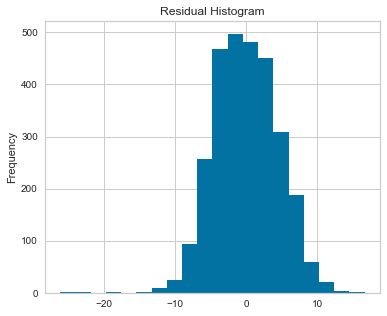

In [32]:
fig, ax = plt.subplots(figsize=(6,5))
resids = y_test-lr_grid_cv.predict(X_test)
#resids = resids.abs()
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean_lr_grid_cv=mean(resids_list)
resids_stdev_lr_grid_cv=stdev(resids_list)
resids_array = np.array(resids_list)
print(st.t.interval(0.99, len(resids_array)-1, loc=np.mean(resids_array), scale=st.sem(resids_array)))


In [33]:
resids.abs()

5925     0.048386
4294     6.295055
7120     2.845235
6688     6.507486
7322     0.737502
          ...    
6996     2.078216
3484     6.047174
8097     0.584486
8513    10.494369
5499     1.069989
Name: PE, Length: 2871, dtype: float64

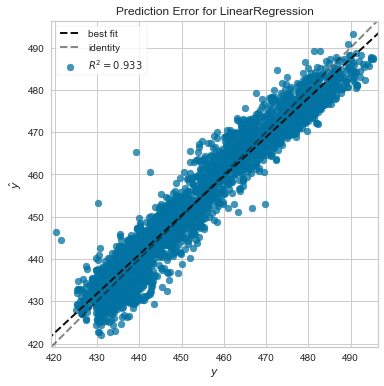

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [34]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(lr_grid_cv)
pev.fit(X_train,y_train)
R2_lr_grid_cv=pev.score(X_test,y_test)
adjusted_r_squared_lr_grid_cv = 1 - (1-R2_lr_grid_cv)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
pev.poof()

In [35]:
print(adjusted_r_squared_lr_grid_cv)
print(R2_lr_grid_cv)

0.9331751660477938
0.9332150853034403


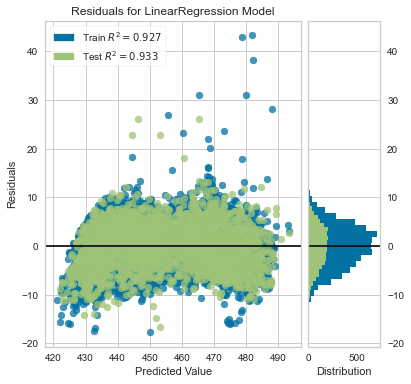

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [36]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(lr_grid_cv)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()

 <b>4.4.2 Random Forest Model Residuals <b/>

-0.0985128945060397
0.13715421112029258


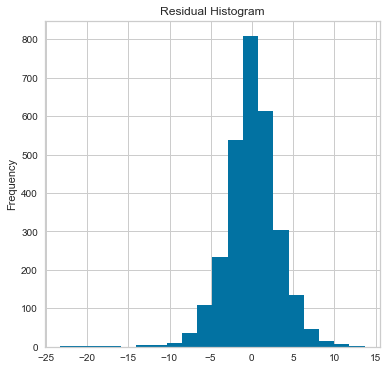

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
resids = y_test-rf_grid_cv.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean_rf_grid_cv=mean(resids_list)
resids_stdev_rf_grid_cv=stdev(resids_list)
n = len(resids) # number of obs
z = 1.96 # for a 95% CI
lower_rf_grid_cv = resids_mean_rf_grid_cv - (z * (resids_stdev_rf_grid_cv/math.sqrt(n)))
upper_rf_grid_cv = resids_mean_rf_grid_cv + (z * (resids_stdev_rf_grid_cv/math.sqrt(n)))
print(lower_rf_grid_cv)
print(upper_rf_grid_cv)

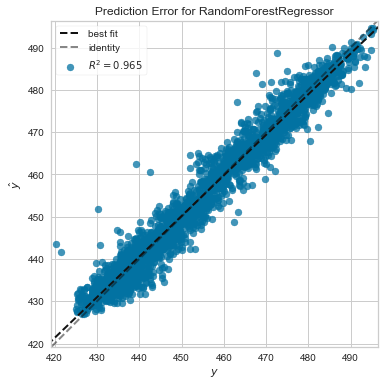

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [38]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(rf_grid_cv)
pev.fit(X_train,y_train)
R2_rf_grid_cv=pev.score(X_test,y_test)
adjusted_r_squared_rf_grid_cv= 1 - (1-R2_rf_grid_cv)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
pev.poof()

In [39]:
print(adjusted_r_squared_rf_grid_cv)
print(R2_rf_grid_cv)

0.9649751565539405
0.9649960793994877


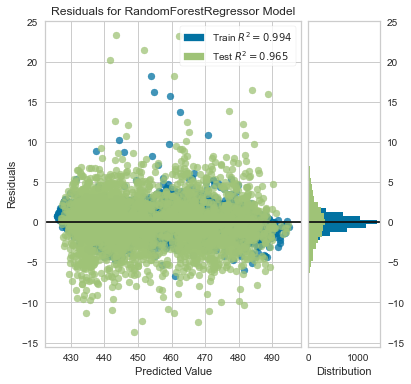

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [40]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(rf_grid_cv)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()

 <b>4.4.3 AdaBoost Model Residuals <b/>

0.28168673117797155
0.6292608698788111


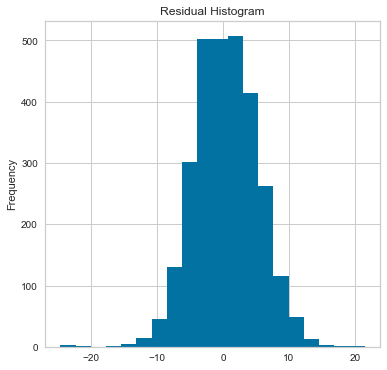

In [41]:
fig, ax = plt.subplots(figsize=(6,6))
resids = y_test-AdaBoost_grid_cv.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean_AdaBoost_grid_cv=mean(resids_list)
resids_stdev_AdaBoost_grid_cv=stdev(resids_list)
n = len(resids) # number of obs
z = 1.96 # for a 95% CI
lower_AdaBoost_grid_cv = resids_mean_AdaBoost_grid_cv - (z * (resids_stdev_AdaBoost_grid_cv/math.sqrt(n)))
upper_AdaBoost_grid_cv = resids_mean_AdaBoost_grid_cv + (z * (resids_stdev_AdaBoost_grid_cv/math.sqrt(n)))
print(lower_AdaBoost_grid_cv)
print(upper_AdaBoost_grid_cv)

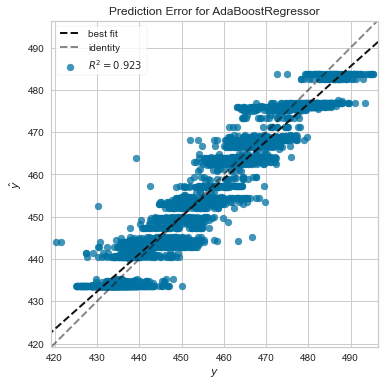

<AxesSubplot:title={'center':'Prediction Error for AdaBoostRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [42]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(AdaBoost_grid_cv)
pev.fit(X_train,y_train)
R2_AdaBoost_grid_cv=pev.score(X_test,y_test)
adjusted_r_squared_AdaBoost_grid_cv= 1 - (1-R2_AdaBoost_grid_cv)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
pev.poof()

In [43]:
print(adjusted_r_squared_AdaBoost_grid_cv)
print(R2_AdaBoost_grid_cv)

0.9231166374388542
0.9231625653734785


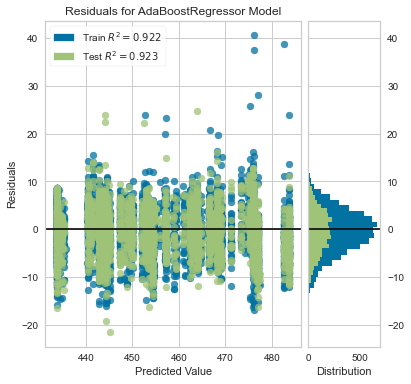

<AxesSubplot:title={'center':'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [44]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(AdaBoost_grid_cv)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()

 <b>4.4.4 GradientBoost Model Residuals <b/>

-0.08599099631618082
0.12957182139571663


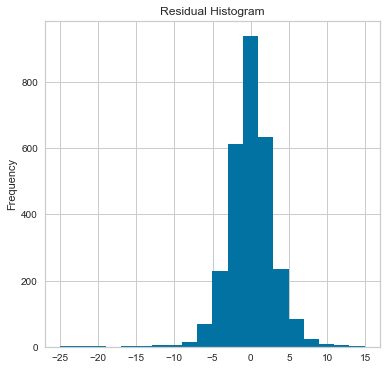

In [45]:
fig, ax = plt.subplots(figsize=(6,6))
resids = y_test-GradientBoost_grid_cv.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean_GradientBoost_grid_cv=mean(resids_list)
resids_stdev_GradientBoost_grid_cv=stdev(resids_list)
n = len(resids) # number of obs
z = 1.96 # for a 95% CI
lower_GradientBoost_grid_cv = resids_mean_GradientBoost_grid_cv - (z * (resids_stdev_GradientBoost_grid_cv/math.sqrt(n)))
upper_GradientBoost_grid_cv = resids_mean_GradientBoost_grid_cv + (z * (resids_stdev_GradientBoost_grid_cv/math.sqrt(n)))
print(lower_GradientBoost_grid_cv)
print(upper_GradientBoost_grid_cv)

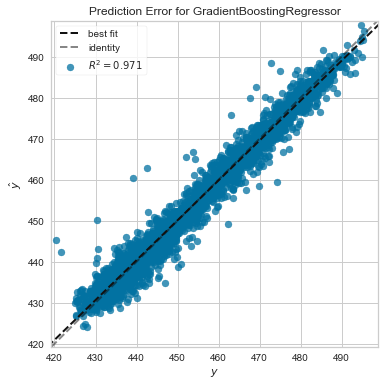

<AxesSubplot:title={'center':'Prediction Error for GradientBoostingRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [46]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(GradientBoost_grid_cv)
pev.fit(X_train,y_train)
R2_GradientBoost_grid_cv=pev.score(X_test,y_test)
adjusted_r_squared_GradientBoost_grid_cv= 1 - (1-R2_GradientBoost_grid_cv)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
pev.poof()

In [47]:
print(adjusted_r_squared_GradientBoost_grid_cv)
print(R2_GradientBoost_grid_cv)

0.9706955144236584
0.970713020090072


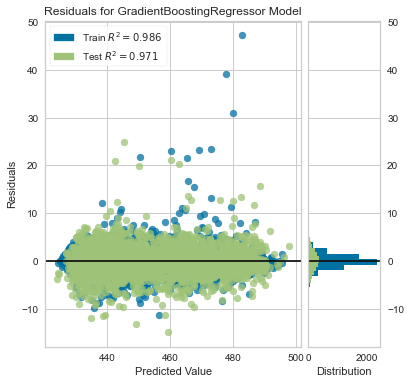

<AxesSubplot:title={'center':'Residuals for GradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [48]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(GradientBoost_grid_cv)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()

 <b>4.4.5 Multi-layer Perceptron Model Residuals <b/>

-0.10070870147316682
0.1858338432230434


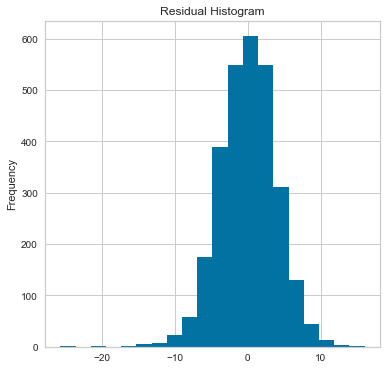

In [49]:
fig, ax = plt.subplots(figsize=(6,6))
resids = y_test-MLP_grid_cv.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean_MLP_grid_cv=mean(resids_list)
resids_stdev_MLP_grid_cv=stdev(resids_list)
n = len(resids) # number of obs
z = 1.96 # for a 95% CI
lower_MLP_grid_cv = resids_mean_MLP_grid_cv - (z * (resids_stdev_MLP_grid_cv/math.sqrt(n)))
upper_MLP_grid_cv = resids_mean_MLP_grid_cv + (z * (resids_stdev_MLP_grid_cv/math.sqrt(n)))
print(lower_MLP_grid_cv)
print(upper_MLP_grid_cv)

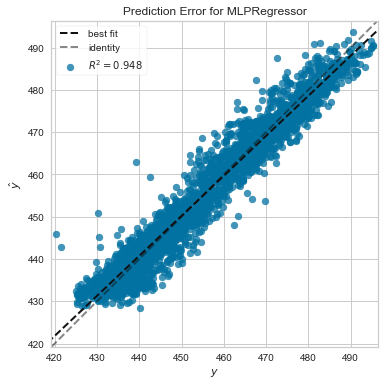

<AxesSubplot:title={'center':'Prediction Error for MLPRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [50]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(MLP_grid_cv)
pev.fit(X_train,y_train)
R2_MLP_grid_cv=pev.score(X_test,y_test)
adjusted_r_squared_MLP_grid_cv= 1 - (1-R2_MLP_grid_cv)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
pev.poof()

In [51]:
print(adjusted_r_squared_MLP_grid_cv)
print(R2_MLP_grid_cv)

0.94821640871004
0.9482473427550161


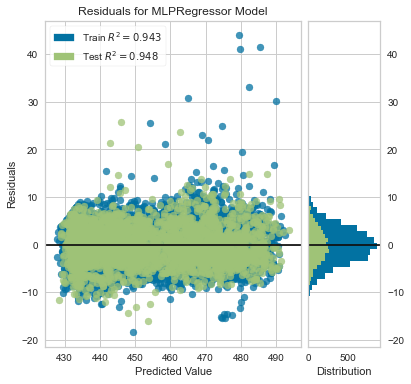

<AxesSubplot:title={'center':'Residuals for MLPRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [52]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(MLP_grid_cv)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()

 <b>4.4.6 XGBoost Model  <b/>

-0.0388206838766897
0.1677091679904567


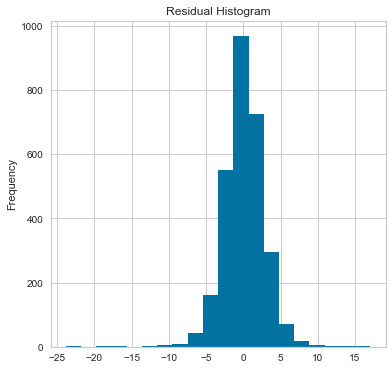

In [53]:
fig, ax = plt.subplots(figsize=(6,6))
resids = y_test-XGBoost_grid_cv.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean_XGBoost_grid_cv=mean(resids_list)
resids_stdev_XGBoost_grid_cv=stdev(resids_list)
n = len(resids) # number of obs
z = 1.96 # for a 95% CI
lower_XGBoost_grid_cv = resids_mean_XGBoost_grid_cv - (z * (resids_stdev_XGBoost_grid_cv/math.sqrt(n)))
upper_XGBoost_grid_cv = resids_mean_XGBoost_grid_cv + (z * (resids_stdev_XGBoost_grid_cv/math.sqrt(n)))
print(lower_XGBoost_grid_cv)
print(upper_XGBoost_grid_cv)

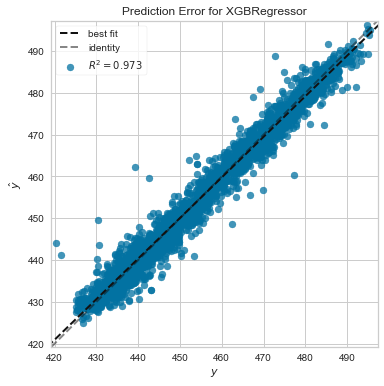

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [55]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(XGBoost_grid_cv)
pev.fit(X_train,y_train)
R2_XGBoost_grid_cv=pev.score(X_test,y_test)
adjusted_r_squared_XGBoost_grid_cv= 1 - (1-R2_XGBoost_grid_cv)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
pev.poof()

In [56]:
print(adjusted_r_squared_XGBoost_grid_cv)
print(R2_XGBoost_grid_cv)

0.9730874625688244
0.9731035393534309


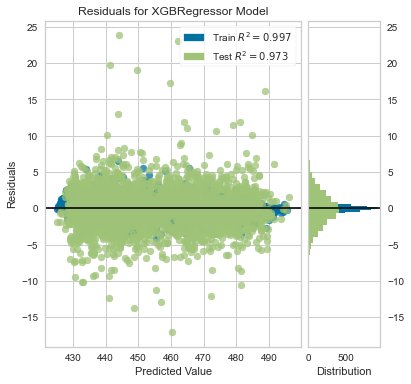

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [57]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(XGBoost_grid_cv)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()

 <b>4.5 Metrics of Models  <b/>

In [59]:
Model_Scores= {'Model': ['Best Linear Regression Model','Best Random Forest Model','Best AdaBoost Model', 'Best GradientBoost Model', 'Best Multi-layer Perceptron Model', 'Best XGBoost Model'],
               'Average Residuals': [resids_mean_lr_grid_cv,resids_mean_rf_grid_cv,resids_mean_AdaBoost_grid_cv,resids_mean_GradientBoost_grid_cv,resids_mean_MLP_grid_cv,resids_mean_XGBoost_grid_cv],
               'Standard Deviation of Residuals': [resids_stdev_lr_grid_cv,resids_mean_rf_grid_cv,resids_mean_AdaBoost_grid_cv,resids_mean_GradientBoost_grid_cv,resids_mean_MLP_grid_cv,resids_mean_XGBoost_grid_cv],
               'R Squared': [R2_lr_grid_cv,R2_rf_grid_cv,R2_AdaBoost_grid_cv,R2_GradientBoost_grid_cv,R2_MLP_grid_cv,R2_XGBoost_grid_cv],
               'Adjusted R Squared': [adjusted_r_squared_lr_grid_cv,adjusted_r_squared_rf_grid_cv,adjusted_r_squared_AdaBoost_grid_cv,adjusted_r_squared_GradientBoost_grid_cv,adjusted_r_squared_MLP_grid_cv,adjusted_r_squared_XGBoost_grid_cv],
              'Mean Absolute Error': [mean_absolute_error(y_test, lr_grid_cv.predict(X_test)),mean_absolute_error(y_test, rf_grid_cv.predict(X_test)),mean_absolute_error(y_test, AdaBoost_grid_cv.predict(X_test)),mean_absolute_error(y_test, GradientBoost_grid_cv.predict(X_test)),mean_absolute_error(y_test, MLP_grid_cv.predict(X_test)),mean_absolute_error(y_test, XGBoost_grid_cv.predict(X_test))]                                                          
              }
              

In [60]:
pd.DataFrame.from_dict(Model_Scores)


,Model,Average Residuals,Standard Deviation of Residuals,R Squared,Adjusted R Squared,Mean Absolute Error
0,Best Linear Regression Model,0.030635,4.449466,0.933215,0.933175,3.587932
1,Best Random Forest Model,0.019321,0.019321,0.964996,0.964975,2.354754
2,Best AdaBoost Model,0.455474,0.455474,0.923163,0.923117,3.793316
3,Best GradientBoost Model,0.021790,0.021790,0.970713,0.970696,2.131491
4,Best Multi-layer Perceptron Model,0.042563,0.042563,0.948247,0.948216,3.050394
5,Best XGBoost Model,0.064444,0.064444,0.973104,0.973087,2.034630


 <b>4.6 Feauture Importance - Best XGBooost Model <b/>

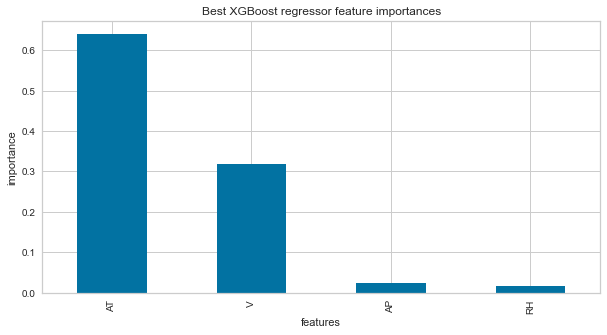

In [62]:
plt.subplots(figsize=(10, 5))
imps = XGBoost_grid_cv.named_steps.xgbregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best XGBoost regressor feature importances');